In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from joblib import load
from models import LitModel
from layers import ATAT
from elasticc import ElasticcDataset, get_dataloader, ForcedDataset
from custom_parser import parse_model_args, handler_parser
from utils.plottinglib import elasticc_confusion_matrix
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
import glob
import os
import matplotlib.pyplot as plt

In [2]:
code_dict_forced = {
    "SNIa": "0",
    "SNIbc": "1",
    "SNII": "2",
    "SNIIb": "3",
    "SNIIn": "4",
    "SLSN": "5",
    "TDE": "6",
    "Microlensing": "7",
    "QSO": "8",
    "AGN": "9",
    "Blazar": "10",
    "YSO": "11",
    "CVNova": "12",
    "LPV": "13",
    "EA": "14",
    "EBEW": "15",
    "Periodic-Other": "16",
    "RSCVn": "17",
    "CEP": "18",
    "RRLab": "19",
    "RRLc": "20",
    "DSCT": "21",
}

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-802fb5a9-d98a-5bce-ad53-9227189dc2cf"

In [4]:
args = handler_parser(vars(parse_model_args([])))
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
balto_path_ = "/home/bgamboa/elasticc_one/src/results/balto_only_lc_mta_with_no_features_update_dic/"
balto_path__ = "/home/bgamboa/elasticc_one/src/results/balto_only_lc_mta_with_features_update_dic_metadata/"


paths = [balto_path_, balto_path__]

In [6]:
history = {}


for path in paths:
    history[path] = {}

    args_path = glob.glob(path + "*args*")[0]
    ckpt_path = glob.glob(path + "*my_best_checkpoin*")[0]

    balto_args = load(args_path)

    model_balto = ATAT(**balto_args)
    checkpoint_balto = torch.load(ckpt_path)

    from collections import OrderedDict

    od_messi = OrderedDict()
    for key in checkpoint_balto["state_dict"].keys():
        # deleting prefix encoder from PL
        od_messi[key.replace("atat.", "")] = checkpoint_balto["state_dict"][key]

    model_balto.load_state_dict(od_messi)

    data_loader_test = get_dataloader(
        dataset_used=ForcedDataset(
            data_root=balto_args["general"]["src_data"] + "/FORCED",
            set_type="test",
            **balto_args["general"]
        ),
        set_type="test",
    )

    model_balto.to(device=device)
    model_balto.eval()

    for i, batch in enumerate(data_loader_test):
        with torch.no_grad():
            batch_data, label = batch
            input_dict = {
                "data": batch_data["data"].float().to(device=device),
                "time": batch_data["time"].float().to(device=device),
                "mask": batch_data["mask"].float().to(device=device),
            }

            try:
                input_dict.update(
                    {
                        "tabular_feat": batch_data["tabular_feat"]
                        .float()
                        .unsqueeze(2)
                        .to(device=device)
                    }
                )

            except:
                pass

            pred_lc, pred_tab, pred_mix = model_balto(**input_dict)

            probs_lc_out = (
                torch.cat([probs_lc_out, pred_lc.to(device="cpu")], axis=0)
                if i != 0
                else pred_lc.to(device="cpu")
            )

            probs_ft_out = (
                torch.cat([probs_ft_out, pred_tab.to(device="cpu")], axis=0)
                if i != 0
                else pred_tab.to(device="cpu")
            )

            probs_mx_out = (
                torch.cat([probs_mx_out, pred_mix.to(device="cpu")], axis=0)
                if i != 0
                else pred_mix.to(device="cpu")
            )

            label_out = (
                torch.cat([label_out, label.to(device="cpu")], axis=0)
                if i != 0
                else label.to(device="cpu")
            )

    filter_preds_lc = torch.argmax(probs_lc_out, axis=1)
    filter_preds_ft = torch.argmax(probs_ft_out, axis=1)
    filter_preds_mx = torch.argmax(probs_mx_out, axis=1)
    all_preds = [filter_preds_lc, filter_preds_ft, filter_preds_mx]

    history[path]["mx"] = all_preds[2]
    history[path]["ft"] = all_preds[1]
    history[path]["lc"] = all_preds[0]
    history[path]["tr"] = label_out

using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata True, use_features False, use MTA True


# eval at time 8, 16, ... etc 

In [7]:
batch_data.keys()

# new mask operation for each time
# batch_data["mask"][0, :, :] * (
#     batch_data["time_alert"][0, :, :] - batch_data["time_alert"][0, 0, :].min() < 8
# ) * (batch_data["time_photo"][0, :, :] - batch_data["time_photo"][0, 0, :].min() < 8)

dict_keys(['data', 'time', 'time_alert', 'time_photo', 'labels', 'mask', 'idx', 'tabular_feat'])

In [8]:
history_4_time = {}


for path in paths:
    history_4_time[path] = {}

    args_path = glob.glob(path + "*args*")[0]
    ckpt_path = glob.glob(path + "*my_best_checkpoin*")[0]

    balto_args = load(args_path)

    model_balto = ATAT(**balto_args)
    checkpoint_balto = torch.load(ckpt_path)

    from collections import OrderedDict

    od_messi = OrderedDict()
    for key in checkpoint_balto["state_dict"].keys():
        # deleting prefix encoder from PL
        od_messi[key.replace("atat.", "")] = checkpoint_balto["state_dict"][key]

    model_balto.load_state_dict(od_messi)

    model_balto.to(device=device)
    model_balto.eval()

    for time2eval in [8, 16, 32, 64, 128, 256, 512, 1024, 2048]:
        history_4_time[path][time2eval] = {}

        data_loader_test = get_dataloader(
            dataset_used=ForcedDataset(
                data_root=balto_args["general"]["src_data"] + "/FORCED",
                set_type="test",
                evalat=time2eval,
                **balto_args["general"]
            ),
            set_type="test",
        )

        for i, batch in enumerate(data_loader_test):
            with torch.no_grad():
                batch_data, label = batch
                input_dict = {
                    "data": batch_data["data"].float().to(device=device),
                    "time": batch_data["time"].float().to(device=device),
                    "mask": batch_data["mask"].float().to(device=device),
                }

                try:
                    input_dict.update(
                        {
                            "tabular_feat": batch_data["tabular_feat"]
                            .float()
                            .unsqueeze(2)
                            .to(device=device)
                        }
                    )

                except:
                    pass

                pred_lc, pred_tab, pred_mix = model_balto(**input_dict)

                probs_lc_out = (
                    torch.cat([probs_lc_out, pred_lc.to(device="cpu")], axis=0)
                    if i != 0
                    else pred_lc.to(device="cpu")
                )

                probs_ft_out = (
                    torch.cat([probs_ft_out, pred_tab.to(device="cpu")], axis=0)
                    if i != 0
                    else pred_tab.to(device="cpu")
                )

                probs_mx_out = (
                    torch.cat([probs_mx_out, pred_mix.to(device="cpu")], axis=0)
                    if i != 0
                    else pred_mix.to(device="cpu")
                )

                label_out = (
                    torch.cat([label_out, label.to(device="cpu")], axis=0)
                    if i != 0
                    else label.to(device="cpu")
                )

        filter_preds_lc = torch.argmax(probs_lc_out, axis=1)
        filter_preds_ft = torch.argmax(probs_ft_out, axis=1)
        filter_preds_mx = torch.argmax(probs_mx_out, axis=1)
        all_preds = [filter_preds_lc, filter_preds_ft, filter_preds_mx]

        history_4_time[path][time2eval]["mx"] = all_preds[2]
        history_4_time[path][time2eval]["ft"] = all_preds[1]
        history_4_time[path][time2eval]["lc"] = all_preds[0]
        history_4_time[path][time2eval]["tr"] = label_out

using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata False, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata True, use_features False, use MTA True
using set test total of idx : 3743 , use_metadata True, use_features False, use MTA True
using set te

## get predictions for each classifier

In [9]:
classes_ = np.array(list(code_dict_forced.keys()))

In [10]:
history[paths[1]].keys()

dict_keys(['mx', 'ft', 'lc', 'tr'])

In [11]:
history_4_time[paths[1]].keys()

dict_keys([8, 16, 32, 64, 128, 256, 512, 1024, 2048])

Normalized confusion matrix


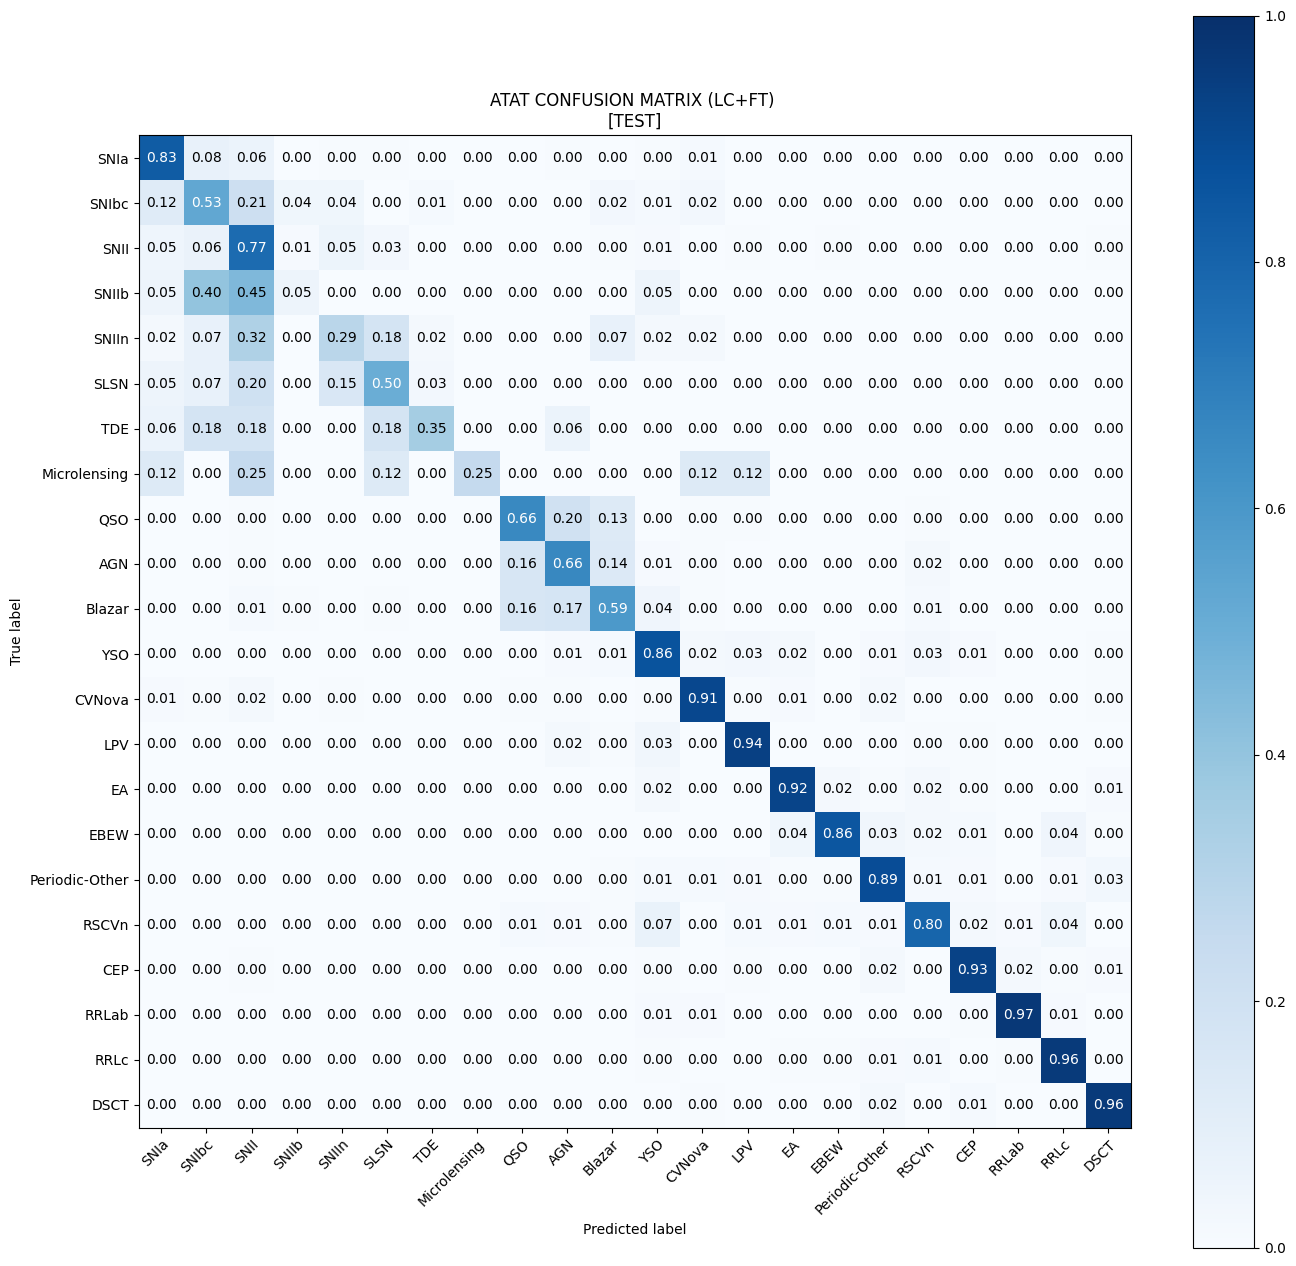

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(16, 16))


time2eval = 2048

target_pred = history_4_time[paths[1]][time2eval]["mx"]
label_true = history_4_time[paths[1]][time2eval]["tr"]

elasticc_confusion_matrix(
    y_true=label_out,
    y_pred=target_pred,
    classes=classes_,
    ax=axes,
    normalize=True,
    title=f"ATAT CONFUSION MATRIX (LC+FT) \n[TEST]",
)


plt.savefig("atat_forced.jpg", format="jpg", bbox_inches="tight")

In [13]:
from sklearn.metrics import classification_report

print(classification_report(label_true, target_pred, target_names=classes_))

                precision    recall  f1-score   support

          SNIa       0.87      0.83      0.85       220
         SNIbc       0.47      0.53      0.50        85
          SNII       0.67      0.77      0.72       220
         SNIIb       0.14      0.05      0.07        20
         SNIIn       0.41      0.29      0.34        56
          SLSN       0.48      0.50      0.49        40
           TDE       0.67      0.35      0.46        17
  Microlensing       1.00      0.25      0.40         8
           QSO       0.66      0.66      0.66       220
           AGN       0.62      0.66      0.64       220
        Blazar       0.65      0.59      0.62       220
           YSO       0.79      0.86      0.82       220
        CVNova       0.91      0.91      0.91       220
           LPV       0.93      0.94      0.93       221
            EA       0.92      0.92      0.92       220
          EBEW       0.94      0.86      0.90       221
Periodic-Other       0.87      0.89      0.88  

In [24]:
from sklearn.metrics import f1_score, accuracy_score, recall_score


acc = []
f1s = []
rcl = []


acc_feats = []
f1s_feats = []
rcl_feats = []


for key_exp in history_4_time[paths[0]].keys():
    data = history_4_time[paths[0]][key_exp]

    acc.append(accuracy_score(data["tr"], data["mx"]))
    f1s.append(f1_score(data["tr"], data["mx"], average="macro"))
    rcl.append(recall_score(data["tr"], data["mx"], average="macro"))

    data = history_4_time[paths[1]][key_exp]

    acc_feats.append(accuracy_score(data["tr"], data["mx"]))
    f1s_feats.append(f1_score(data["tr"], data["mx"], average="macro"))
    rcl_feats.append(recall_score(data["tr"], data["mx"], average="macro"))

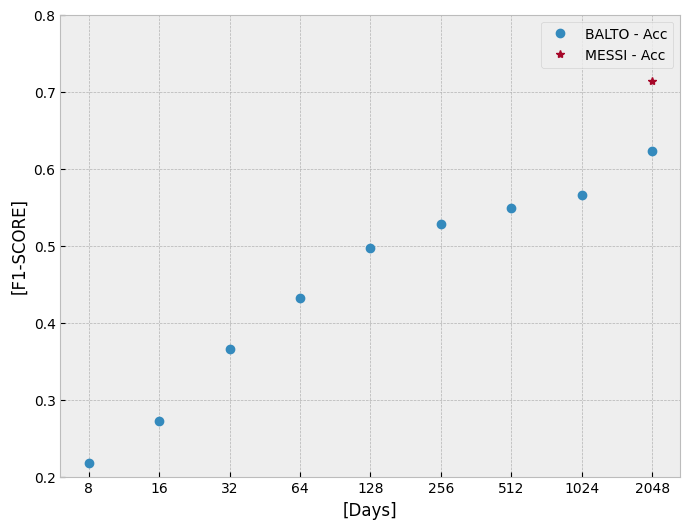

In [25]:
times = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
x_times = [str(t) for t in times]
plt.style.use("bmh")

fig, axes = plt.subplots(1, 1, figsize=(8, 6))


axes.plot(x_times, f1s, "o", label="BALTO - Acc")
axes.plot(x_times[-1], f1s_feats[-1], "*", label="MESSI - Acc")
# axes.set_xscale('log')

# for i in range(2):
axes.set_ylim([0.2, 0.8])
axes.set_xlabel("[Days]")
axes.set_ylabel("[F1-SCORE]")
axes.legend()

In [43]:
df_forced = pd.DataFrame()

df_forced["@day"] = x_times
df_forced["balto-ztf-acc"] = acc
df_forced["balto-ztf-f1s"] = f1s
df_forced["messi-ztf-acc"] = [np.nan] * 7 + acc_feats[7:]
df_forced["messi-ztf-f1s"] = [np.nan] * 7 + f1s_feats[7:]

In [44]:
df_forced.to_parquet("ztf_metrics.parquet")

In [45]:
df_forced

,@day,balto-ztf-acc,balto-ztf-f1s,messi-ztf-acc,messi-ztf-f1s
0,8,0.250868,0.217717,NaN,NaN
1,16,0.317125,0.272592,NaN,NaN
2,32,0.426930,0.366164,NaN,NaN
3,64,0.500935,0.431947,NaN,NaN
4,128,0.568261,0.496269,NaN,NaN
5,256,0.606733,0.527866,NaN,NaN
6,512,0.634251,0.548332,NaN,NaN
7,1024,0.662303,0.565136,0.801496,0.700543
8,2048,0.726957,0.622610,0.816725,0.713748


In [35]:
acc_feats[7:]

[0.8014961261020572, 0.8167245524979962]

In [40]:
acc_feats[7:]

[0.8014961261020572, 0.8167245524979962]

In [41]:
acc

[0.2508682874699439,
 0.31712530056104726,
 0.42693026983702914,
 0.5009350788137857,
 0.5682607534063585,
 0.6067325674592573,
 0.6342506011220945,
 0.6623029655356666,
 0.7269569863745659]